In [235]:
import pandas as pd
import numpy as np
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import re
import os
import time
import seaborn as sb
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from numpy import nan

In [2]:
stop_words = set(stopwords.words('english'))

In [3]:
dictionary = []

In [195]:
embeddings = {}

In [5]:
df = pd.read_csv("data/dataset/train-balanced-sarcasm.csv")

In [6]:
df_new = df[['parent_comment','comment','label']]

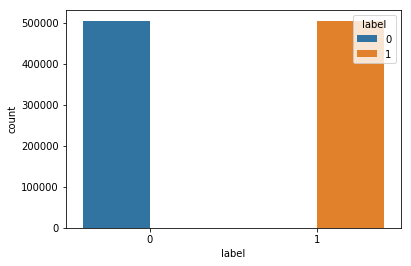

In [7]:
sb.countplot(x='label',hue='label',data=df_new)

In [8]:
df_new = df_new.sample(100000)

In [9]:
df_new.shape

(100000, 3)

In [10]:
df_new.head()

,parent_comment,comment,label
420656,The pilot could not be shot dead from the grou...,*cough* parachute,0
822050,"A bunch of guys go to Normandy to find Ryan, a...",WOAH SPOILER ALERT,1
848304,Found this Richmond ad browsing in r/wtf.,"Think of the cleanup job, arrggg so gross",0
537018,dibidy dont,dibididbidibidiidbidibdi,0
269018,The fence that encloses the smallest area in t...,"Nuh uh, cuz the Earth is flat",1


In [11]:
def remove_stopwords(tokens):
    tokens_wo_stopwords = []
    for i in range(0,len(tokens)):
        if tokens[i].lower() not in stop_words:
            tokens_wo_stopwords.append(tokens[i].lower())
    return tokens_wo_stopwords

In [12]:
def get_pos_tag(token):
    pos_tag = nltk.pos_tag([token])[0][1]
    if pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [13]:
def lemmatize(tokens):
    lemmatizer = WordNetLemmatizer()
    for i in range(0,len(tokens)):
        tokens[i] = lemmatizer.lemmatize(tokens[i],pos=str(get_pos_tag(tokens[i])))
    return tokens

In [14]:
def add_to_dictionary(tokens):
    for token in tokens:
        if token not in dictionary:
            dictionary.append(token)

In [15]:
def save_dictionary():
    with open('data/processed/dictionary.txt','w') as file:
        file.writelines("%s\n" % word for word in dictionary)

In [16]:
def read_dictionary():
    with open('data/processed/dictionary.txt','r') as file:
        temp = file.read().splitlines()
        for i in range(0,len(temp)):
            dictionary.append(temp[i])

In [17]:
def preprocess(sentence):
    processed_sentence = re.sub(r'[^a-zA-Z]', ' ', sentence)
    tokens_comment = word_tokenize(processed_sentence)
    tokens_comment = remove_stopwords(tokens_comment)
    tokens_comment = lemmatize(tokens_comment)
    return tokens_comment

In [18]:
def create_dictionary(dataset):
    for index,row in dataset.iterrows():
        tokens_comment = preprocess(str(row['parent_comment']) + " " + str(row['comment']))
        add_to_dictionary(tokens_comment)
    save_dictionary()

In [196]:
def populate_embeddings_dict():
    starttime = time.time()
    with open('data/processed/glove.6B.300d.txt','r') as file:
        for line in file:
            values = line.split()
            word = values[0]
            word_embedding = np.asarray(values[1:])
            embeddings[word] = word_embedding
    endtime = time.time()
    print("Time taken to load embeddings:- ")
    print(endtime - starttime)

In [286]:
def embedding_lookup(x,embedding_dim=300):
    if(len(embeddings) == 0):
        populate_embeddings_dict()
    embedding = []
    for i in range(0,len(x)):
        if(x[i] in embeddings):
            embedding.append(embeddings[x[i]])
        else:
            zero_arr = np.zeros(embedding_dim).tolist()
            embedding.append(zero_arr)
    return np.array(embedding)

In [21]:
if not os.path.isfile('data/processed/dictionary.txt'):
    starttime = time.time()
    create_dictionary(df_new)
    endtime = time.time()
    print("Time to create dictionary")
    print(endtime - starttime)
else:   
    read_dictionary()

In [22]:
len(dictionary)

67028

In [23]:
embeddings = v

Time taken to load embeddings:- 
26.129017114639282


In [24]:
preprocess(df_new['comment'].iloc[0])

['cough', 'parachute']

In [300]:
elmo = hub.Module("https://tfhub.dev/google/elmo/2",trainable=True)

In [301]:
def get_elmo_embeddings(sess,tokens_input,tokens_length):
    embeddings = elmo(inputs={"tokens": tokens_input,"sequence_len": tokens_length},signature='tokens',as_dict=True)["elmo"]
    return sess.run(embeddings)

In [322]:
tokens = preprocess(df_new['comment'].iloc[0])
tokens_input = [tokens]
tokens_length = [len(tokens)]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    elmo_embeddings = get_elmo_embeddings(sess,tokens_input,tokens_length)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0412 21:44:46.317991 4423882176 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


In [323]:
elmo_embeddings.shape

(1, 2, 1024)

In [324]:
print("ELMO embeddings for 'cool'")
elmo_embeddings[0][0]

ELMO embeddings for 'cool'


array([ 1.1345155 , -0.19303311,  0.17593093, ...,  0.47150755,
        0.02966034,  0.46326378], dtype=float32)

In [33]:
def generate_elmo_embedding():
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.tables_initializer())
        for index,rows in df_new.iterrows():
            preprocessed_tokens = preprocess(rows['parent_comment'] + " " + rows['comment'])
            embedding_tensor = elmo(preprocessed_tokens)
            embeddings = sess.run(embedding_tensor)
            #Rest of the network here

In [113]:
class LSTM():
    
    def __init__(self,num_classes,elmo_embed_size,embed_size,batch_size,epochs,max_length):
        self.X = tf.placeholder(shape=[None,max_length,embed_size + elmo_embed_size],dtype=tf.float32)
        self.y = tf.placeholder(shape=[None],dtype=tf.int64)
        self.sequence_lengths = tf.placeholder(shape=[None],dtype=tf.int32)
        self.num_classes = num_classes
        self.elmo_embed_size = elmo_embed_size
        self.embed_size = embed_size
        self.hidden_size = elmo_embed_size + embed_size
        self.batch_size = batch_size
        self.epochs = epochs
        self.max_length = max_length
        self.model()
    
    def model(self):
        cell_fw = tf.contrib.rnn.LSTMCell(self.hidden_size,forget_bias=1.0,state_is_tuple=True,reuse=tf.get_variable_scope().reuse)
        cell_bw = tf.contrib.rnn.LSTMCell(self.hidden_size,forget_bias=1.0,state_is_tuple=True,reuse=tf.get_variable_scope().reuse)
        with tf.variable_scope('Bi-Directional-LSTM',reuse=tf.AUTO_REUSE):
            output_vals,output_states = tf.nn.bidirectional_dynamic_rnn(
            cell_fw = cell_fw,
            cell_bw = cell_bw,
            inputs = self.X,
            sequence_length = self.sequence_lengths,
            dtype = tf.float32)
        self.final_state = tf.concat([output_states[0].c,output_states[1].c],axis=1)
        with tf.variable_scope('Softmax',reuse=tf.AUTO_REUSE):
            self.softmax_w = tf.get_variable('softmax_w',shape=[2 * self.hidden_size,self.num_classes],initializer=tf.truncated_normal_initializer(),dtype=tf.float32)
            self.softmax_b = tf.get_variable('softmax_b',shape=[self.num_classes],initializer=tf.constant_initializer(0.0),dtype=tf.float32)
        self.logits = tf.matmul(self.final_state,self.softmax_w) + self.softmax_b
        self.predictions = tf.argmax(tf.nn.softmax(self.logits),1,name='predictions')
        self.cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=self.y,logits=self.logits))
        self.accuracy = tf.reduce_mean(tf.cast(tf.equal(self.predictions,self.y),tf.float32),name='accuracy')
    
    def train(self,X_train,X_test,y_train,y_test,sequence_lengths_train,sequence_lengths_test):
        self.learning_rate = tf.train.exponential_decay(1e-3,global_step,15,1,staircase=True)
        optimizer = tf.train.AdamOptimizer(lr=self.learning_rate)
        train_step = optimizer.minimize(self.cost)
        with tf.Graph().as_deafult():
            with tf.Session() as sess:
                sess.run(tf.global_variables_initializer())
                for j in range(0,self.epochs):
                    for i in range(0,X_train.shape[0],self.batch_size):
                        X_train_batch = X_train[i * self.batch_size : min(i * (self.batch_size + 1) - 1,X_train.shape[0] - (i * self.batch_size) + 1)]
                        y_train_batch = y_train[i * self.batch_size : min(i * (self.batch_size + 1) - 1,y_train.shape[0] - (i * self.batch_size) + 1)]
                        sequence_lengths_batch = sequence_lengths_train[i * self.batch_size : min(i * (self.batch_size + 1) - 1,sequence_lengths_train.shape[0] - (i * self.batch_size) + 1)]
                        fetches = {
                            'cost': self.cost,
                            'accuracy': self.accuracy,
                            'predictions': self.predictions
                        }
                        feed_dict = {
                            'X': X_train_batch,
                            'y': y_train_batch,
                            'sequence_lengths': sequence_lengths_batch
                        }
                        resp = sess.run(fetched,feed_dict)
                    print(resp['accuracy'])

In [114]:
#Hyperparameter tuning required
lstm = LSTM(2,1024,300,4000,5,100)

In [186]:
#Remove nan here
X = df_new['comment']
y = df_new['label']
X.reset_index()
print(X.head())
X_train,X_test,y_train,t_test = train_test_split(X,y,test_size=0.2,random_state=222)

420656                            *cough* parachute
822050                           WOAH SPOILER ALERT
848304    Think of the cleanup job, arrggg so gross
537018                     dibididbidibidiidbidibdi
269018                Nuh uh, cuz the Earth is flat
Name: comment, dtype: object


In [272]:
X_train.shape

(80000,)

In [187]:
X_train.index

Int64Index([533199, 415545, 815276, 709403, 275380, 305515, 487810, 173348,
            872728, 927082,
            ...
            829183, 783248, 255816, 964228, 226890,  46567, 988743, 479766,
            742475, 424065],
           dtype='int64', length=80000)

In [198]:
X_test.shape

(20000,)

In [199]:
X_test.index

Int64Index([555725, 240091, 978765,  60492, 173865,  60919, 905619, 602610,
            708643, 684005,
            ...
            607571, 335253,    156, 203365,  75947, 699733, 712162, 943482,
            929689, 331835],
           dtype='int64', length=20000)

In [287]:
def pad_tokens(tokens,max_length):
    zeros = np.zeros(len(tokens[0]))
    while len(tokens) < max_length:
        tokens = np.vstack([tokens,zeros])
    return tokens

In [244]:
def get_max_length():
    max_length = 0
    index = 0
    for i in range(0,len(X_train.index)):
        if(X_train[i:i+1][X_train.index[i]] is not nan):
            preprocessed_tokens = preprocess(X_train[i:i+1][X_train.index[i]])
            if(len(preprocessed_tokens) < 100):
                if max_length < len(preprocessed_tokens):
                    max_length = len(preprocessed_tokens)
                    index = i
    print(index)
    print(preprocess(X_train[index:index+1][X_train.index[index]]))
    return max_length

In [270]:
starttime = time.time()
max_length = get_max_length()
endtime = time.time()
print("Time to calculate max length:- ")
print(endtime - starttime)
print("Max length:- ")
print(max_length)

21596
['v', 'jul', 'v', 'jul', 'v', 'jul', 'v', 'jun', 'v', 'jun', 'v', 'mar', 'v', 'feb', 'v', 'feb', 'v', 'feb', 'v', 'jan', 'v', 'dec', 'v', 'dec', 'v', 'sep', 'v', 'aug', 'v', 'jun', 'v', 'apr', 'v', 'mar', 'v', 'feb', 'v', 'feb', 'v', 'dec', 'v', 'dec', 'v', 'nov', 'v', 'sep', 'v', 'sep', 'v', 'aug', 'v', 'jul', 'v', 'jul', 'v', 'jun', 'v', 'may', 'v', 'apr', 'v', 'mar', 'v', 'mar', 'v', 'feb', 'v', 'feb', 'v', 'feb', 'v', 'jan', 'v', 'jan', 'v', 'jan', 'v', 'dec', 'v', 'dec', 'v', 'dec', 'v', 'dec', 'v', 'dec']
Time to calculate max length:- 
117.96574902534485
Max length:- 
86


In [ ]:
deep_contextualized_embeddings = []
sequence_lengths_train = []
elmo_tokens = []
elmo_tokens_length = []
elmo_embeddings_list = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    starttime = time.time()
    for i in range(0,len(X_train.index)):
        if(X_train[i:i+1][X_train.index[i]] is not nan):
            preprocessed_tokens = preprocess(X_train[i:i+1][X_train.index[i]])
            if(len(preprocessed_tokens) < 100):
                sequence_lengths_train.append(len(preprocessed_tokens))
                for j in range(len(preprocessed_tokens),max_length):
                    preprocessed_tokens.append("<PAD>")
                #word_embedding = embedding_lookup(preprocessed_tokens)
                #word_embedding = np.array(pad_tokens(word_embedding,max_length))
                elmo_tokens.append(preprocessed_tokens)
                elmo_tokens_length.append(len(preprocessed_tokens))
                #deep_contextualized_embeddings.append(np.hstack([word_embedding,elmo_embedding]))
                if (i +1 ) % 1000 == 0:
                    elmo_embedding = get_elmo_embeddings(sess,np.array(elmo_tokens),np.array(elmo_tokens_length))
                    for j in range(0,len(elmo_embedding)):
                        deep_contextualized_embeddings.append(np.array(pad_tokens(elmo_embedding[j],max_length)))
                    temp_arr = np.array(deep_contextualized_embeddings)
                    print(temp_arr.shape)
    endtime = time.time()
    print("Total time to generate embeddings:- ")
    print(endtime - starttime)
    print(deep_contextualized_embeddings.shape)